In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import os
import gc

# Step 1: Feature Engineering
def feature_engineering(data):
    data['SOG_Change'] = data.groupby('MMSI')['SOG'].diff().fillna(0)
    data['COG_Change'] = data.groupby('MMSI')['COG'].diff().fillna(0)
    data['Heading_Change'] = data.groupby('MMSI')['Heading'].diff().fillna(0)
    data['hour'] = pd.to_datetime(data['BaseDateTime']).dt.hour
    data['day_of_week'] = pd.to_datetime(data['BaseDateTime']).dt.dayofweek

    # Rolling statistics
    data['SOG_Roll_Mean'] = data.groupby('MMSI')['SOG'].rolling(window=5).mean().reset_index(0, drop=True)
    data['SOG_Roll_Std'] = data.groupby('MMSI')['SOG'].rolling(window=5).std().reset_index(0, drop=True)
    data.fillna(0, inplace=True)
    return data

# Step 2: Train Isolation Forest
def train_isolation_forest(data, features, contamination=0.05):
    iso_forest = IsolationForest(contamination=contamination, n_estimators=100, random_state=42)
    iso_forest.fit(data[features])
    return iso_forest

# Step 3: Train LSTM Autoencoder
def train_lstm_autoencoder(X_train, timesteps, features_len):
    # Define the LSTM Autoencoder
    input_layer = Input(shape=(timesteps, features_len))
    encoder = LSTM(64, activation='relu', return_sequences=False)(input_layer)
    encoder = RepeatVector(timesteps)(encoder)
    decoder = LSTM(64, activation='relu', return_sequences=True)(encoder)
    output_layer = TimeDistributed(Dense(features_len))(decoder)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the Autoencoder
    autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, shuffle=True, validation_split=0.1)
    return autoencoder

# Step 4: Predict Anomalies in Batches
def predict_anomalies_in_batches(data, iso_forest, autoencoder, features, batch_size=50000, timesteps=10):
    num_rows = data.shape[0]
    all_mse = []
    anomalous_data = []

    csv_file = 'anomaly_detection_results_batch.csv'
    if not os.path.exists(csv_file):
        headers = ['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselName', 'IMO', 'CallSign',
                   'VesselType', 'Status', 'Length', 'Width', 'Draft', 'Cargo', 'TransceiverClass', 'hour', 
                   'day_of_week', 'month', 'status_encoded', 'anomaly']
        pd.DataFrame(columns=headers).to_csv(csv_file, index=False)

    for start_idx in range(0, num_rows, batch_size):
        end_idx = min(start_idx + batch_size, num_rows)
        batch_data = data.iloc[start_idx:end_idx].copy()

        try:
            # Normalize the data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(batch_data[features])

            # Isolation Forest Prediction
            iso_preds = iso_forest.predict(scaled_data)
            batch_data['anomaly_iso'] = np.where(iso_preds == -1, 1, 0)

            # LSTM Autoencoder Prediction
            X_pred = [scaled_data[i-timesteps:i, :] for i in range(timesteps, scaled_data.shape[0])]
            if len(X_pred) > 0:
                X_pred = np.array(X_pred)
                lstm_preds = autoencoder.predict(X_pred)
                mse = np.mean(np.power(X_pred - lstm_preds, 2), axis=(1, 2))
                threshold = np.percentile(mse, 95)
                anomalies = np.zeros(len(batch_data))  
                anomalies[timesteps:] = (mse > threshold).astype(int)  # Set anomalies
                batch_data['anomaly_lstm'] = anomalies

            # Combine anomaly results
            batch_data['anomaly'] = batch_data[['anomaly_iso', 'anomaly_lstm']].max(axis=1)

            # Save batch results to CSV
            batch_data.to_csv(csv_file, mode='a', header=False, index=False)

            # Collect anomalous data
            anomalous_data.append(batch_data[batch_data['anomaly'] == 1])

            # Save MSE values
            all_mse.extend(mse)

            # Free memory after processing each batch
            del batch_data, scaled_data, iso_preds, lstm_preds, anomalies
            gc.collect()

        except Exception as e:
            print(f"Error encountered: {e}")

    if anomalous_data:
        anomalous_df = pd.concat(anomalous_data, ignore_index=True)
        anomalous_df.to_csv('anomalous_ships.csv', index=False)

    return all_mse
# Example Main Process
def main():
    # Load data in chunks
    chunk_size = 1000000  
    data_iterator = pd.read_csv(r"C:\Users\ASUS\AIS_2024_01_01.csv", chunksize=chunk_size)

    iso_forest = None
    autoencoder = None
    timesteps = 10
    features = ['SOG', 'SOG_Change', 'COG', 'COG_Change', 'Heading', 'Heading_Change', 'Status', 
                'SOG_Roll_Mean', 'SOG_Roll_Std', 'hour', 'day_of_week']

    for data_chunk in data_iterator:
        data_chunk = feature_engineering(data_chunk)
        
        # Train Isolation Forest and LSTM Autoencoder only once
        if iso_forest is None:
            iso_forest = train_isolation_forest(data_chunk, features)

        if autoencoder is None:
            # Prepare training data for LSTM Autoencoder
            X_train = []
            scaled_data = StandardScaler().fit_transform(data_chunk[features])
            for i in range(timesteps, scaled_data.shape[0]):
                X_train.append(scaled_data[i-timesteps:i, :])
            if len(X_train) > 0:
                X_train = np.array(X_train)
                autoencoder = train_lstm_autoencoder(X_train, timesteps, len(features))

        # Predict anomalies in batches
        predict_anomalies_in_batches(data_chunk, iso_forest, autoencoder, features)
# Run the process
if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'keras'

In [ ]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\oil_spill11\anomalous_ships.csv")
type = df[df["MMSI"]==368272320


]

type.to_csv('type.csv',index=False)

In [ ]:
unique = df['MMSI'].unique()

In [ ]:
unique

array([367771510, 636020874, 367513170, ..., 368926395, 431128000,
       369493762], dtype=int64)

In [3]:
# Import necessary libraries
import pandas as pd

# Load the CSV data
csv_file_path = 'AIS_2024_01_01.csv'  # Update with the path to your CSV file
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataframe
data.head()

# Get unique MMSI numbers
unique_mmsi = data['MMSI'].drop_duplicates().head(10)

# Display the unique MMSI numbers
unique_mmsi_list = unique_mmsi.tolist()
unique_mmsi_list
print(unique_mmsi_list)


[338075892, 367669550, 367118980, 367177840, 367305420, 338239081, 367507960, 636018568, 366847780, 367468580]


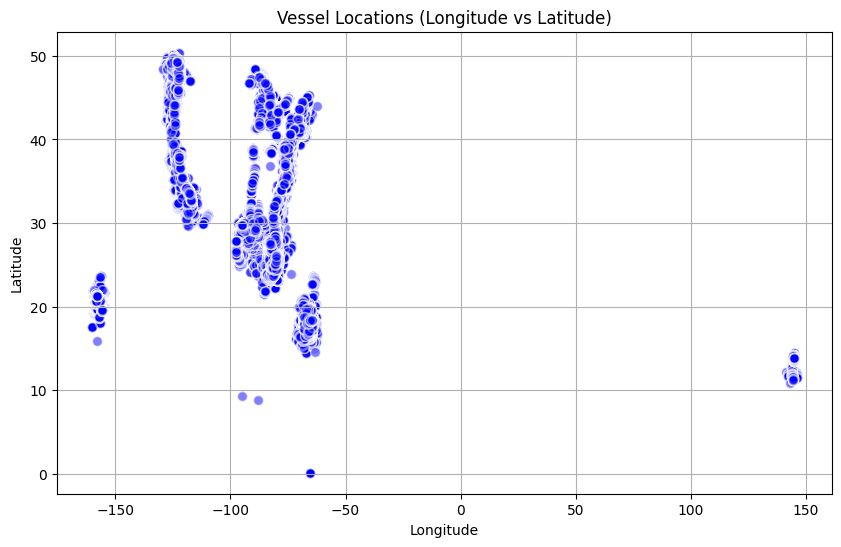

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('AIS_2024_01_01.csv')

# Convert BaseDateTime to datetime object
data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])

# Scatter Plot of Latitude vs Longitude
plt.figure(figsize=(10, 6))
plt.scatter(data['LON'], data['LAT'], c='blue', alpha=0.5, edgecolors='w', s=50)
plt.title('Vessel Locations (Longitude vs Latitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
# Time Series Plot of Speed (SOG)
plt.figure(figsize=(12, 6))
plt.plot(data['BaseDateTime'], data['SOG'], marker='o', linestyle='-', color='r')
plt.title('Speed (SOG) Over Time')
plt.xlabel('DateTime')
plt.ylabel('Speed (SOG)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv('AIS_2024_01_01.csv')
data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
    
df_filtered = df[df['MMSI'] == mmsi]
data_filtered = data()

    
    # Extract time-based features
df_filtered['hour'] = df_filtered['BaseDateTime'].dt.hour
df_filtered['day_of_week'] = df_filtered['BaseDateTime'].dt.dayofweek
df_filtered['month'] = df_filtered['BaseDateTime'].dt.month
    